# Assignment 2 - Simple analytical model        

__41934 - Advanced BIM, E23__


Kaare G. S. Hansen, s214282 - DTU


## Imports

In [6]:
import os
import sys
import multiprocessing
import importlib
from collections import namedtuple
import numpy as np
import pandas as pd
import ifcopenshell
import ifcopenshell.util.placement
import ifcopenshell.geom
import ifcopenshell.util.shape
import ifcopenshell.util.selector

print(f"ifcopenshell version: {ifcopenshell.version}")
print(f"Python-version {sys.version}")

ifcopenshell version: 0.7.0
Python-version 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [23]:
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.gp import gp_Pnt, gp_Ax2, gp_Dir, gp_XYZ
from OCC.Core.BRepBndLib import brepbndlib
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeVertex
from OCC.Core.Bnd import Bnd_OBB
from OCC.Core.BRepTools import breptools_Read
from OCC.Core.TopoDS import TopoDS_Shape, TopoDS_Wire
from OCC.Core.BRep import BRep_Builder
from OCC.Core.GC import GC_MakeArcOfCircle, GC_MakeSegment

from OCC.Display.SimpleGui import init_display
from OCC.Display.OCCViewer import rgb_color

from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Lin
from OCC.Core.Geom import Geom_Line, Geom_Point, Geom_CartesianPoint
from OCC.Core.AIS import AIS_Line, AIS_Point
from OCC.Core.Prs3d import Prs3d_LineAspect, Prs3d_Drawer
from OCC.Core.Quantity import Quantity_Color, Quantity_TOC_RGB
from OCC.Core.Graphic3d import Graphic3d_ZLayerSettings
from OCC.Core.TColStd import TColStd_SequenceOfInteger

import OCC.Core.BRep
import OCC.Core.BRepPrimAPI
import OCC.Core.BRepTools

from OCC.Core.gp import gp_Pnt
from OCC.Core.TopoDS import TopoDS_Vertex
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeVertex
from OCC.Core.BRep import BRep_Tool
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TColgp import TColgp_Array1OfPnt
from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape

from OCC.Core.Prs3d import Prs3d_Text
from OCC.Core.Graphic3d import Graphic3d_Group, Graphic3d_Text
from OCC.Core.TCollection import TCollection_AsciiString, TCollection_ExtendedString
from OCC.Core.Quantity import Quantity_Color
from OCC.Core.gp import gp_Pnt
from OCC.Core.Aspect import Aspect_TOL_SOLID
from OCC.Core.AIS import AIS_TextLabel

from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Common, BRepAlgoAPI_Section, BRepAlgoAPI_BooleanOperation
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeWedge
from OCC.Core.gp import gp_Pnt
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.BRepMesh import BRepMesh_IncrementalMesh
from OCC.Core.BRepExtrema import BRepExtrema_ShapeProximity

In [1]:
from geomUtils import *
from ifcUtils import *
from rendering import *
import geomUtils
import ifcUtils
import rendering
import utils

In [7]:
importlib.reload(geomUtils)
importlib.reload(ifcUtils)
importlib.reload(rendering)
importlib.reload(utils)
from geomUtils import *
from ifcUtils import *
from rendering import *

## Load model

In [2]:
models = load_models(model_dir='/Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab',
                     models={#'ark': 'LLYN - ARK.ifc',
                             'stru': 'LLYN - STRU.ifc',
                             })

File path, stru: /Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab\LLYN - STRU.ifc
Model schema: IFC4



In [3]:
model = models['stru']
modelData = ModelData(model)

Beginning processing with 12 threads...
Progress: 1%
Progress: 28%
Progress: 32%
Progress: 44%
Progress: 100%
Progress: 100%
Progress: 100%
Progress: 100%
Processed 3601 items
Contexts: {'FootPrint', 'Axis', 'Body'}


### Group elements

In [12]:
elements = list(ifcopenshell.util.selector.filter_elements(model,
    "IfcBuildingElement, /Pset_.*Common/.LoadBearing=TRUE"))

elements_loadBearing = {element.GlobalId for element in elements}

elements = list(ifcopenshell.util.selector.filter_elements(model,
    "IfcBuildingElement, /Pset_.*Common/.LoadBearing=FALSE"))

elements_nonloadBearing = {element.GlobalId for element in elements}

elements = model.by_type('IfcBuildingElement')
elements_all = {element.GlobalId for element in elements}

elements = {element.GlobalId: element for element in elements}

print(len(elements_loadBearing))
print(len(elements_nonloadBearing))
print(len(elements_all))

1750
10
1835


In [13]:
elements_nonloadBearing = elements_all.difference(elements_loadBearing)
print(len(elements_nonloadBearing))

85


## Make analytical model

In [14]:
class Knot3D:
    def __init__(self) -> None:
        pass

class StructuralMember:
    def __init__(self) -> None:
        pass

class Beam(StructuralMember):
    def __init__(self, axis) -> None:
        super().__init__()

        assert is_wire_straight_line(axis)
        self.axis = axis

class Column(StructuralMember):
    def __init__(self, axis) -> None:
        super().__init__()

        assert is_wire_straight_line(axis)
        self.axis = axis

class Slab(StructuralMember):
    def __init__(self) -> None:
        super().__init__()


**Initial line model based on provided Axis and OBBs**:

In [19]:
members = dict()

for GUID in elements:
    shapes = modelData.shapes[GUID]
    keys = shapes.keys()
    element = modelData.model.by_guid(GUID)

    assert 'Body' in keys
    
    # Assert that an element doesn't have both Axis and FootPrint
    assert not ('Axis' in keys and 'FootPrint' in keys)

    IfcClass = element.is_a()

    # Beam
    if IfcClass == 'IfcBeam':
        assert 'Axis' in keys

        axis = shapes['Axis'].geometry
        subShapes = get_subShapes(axis)
        assert len(subShapes) == 1
        
        shape = subShapes[0]
        assert is_wire_straight_line(shape)
        wire = shape

        member = Beam(wire)

        members[GUID] = member
        

    # Column
    elif IfcClass == 'IfcColumn':
        body = shapes['Body'].geometry
        obb = modelData.obbs[GUID]

        wire = convert_bnd_to_line(obb, returnWire=True)

        member = Column(wire)
        members[GUID] = member

    # Slab
    elif IfcClass == 'IfcSlab':
        # assert 'FootPrint' in keys
        pass

    # Wall
    elif IfcClass == 'IfcWall':
        pass

    # Plate
    elif IfcClass == 'IfcPlate':
        pass

    else:
        print(f"Unknown class: {IfcClass}")


Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildingElementProxy
Unknown class: IfcBuildin

### Render analytical model

In [24]:
def RenderStructuralMembersFunc(renderer, **args):
    modelData = args['modelData']
    members = args['members']

    RED = Quantity_Color(1.0, 0.0, 0.0, Quantity_TOC_RGB)
    GREEN = Quantity_Color(0.0, 1.0, 0.0, Quantity_TOC_RGB)
    BLUE = Quantity_Color(0.0, 0.0, 1.0, Quantity_TOC_RGB)
    MAGENTA = Quantity_Color(1.0, 0.0, 1.0, Quantity_TOC_RGB)


    # Idea: have render code be part of each Structural Members own class
    transparency = 0.8
    color = Quantity_Color(1.0, 0.0, 0.5, Quantity_TOC_RGB)
    for i,  (GUID, member) in enumerate(members.items()):
        to_update = i % 50 == 0

        try:
            # print(type(member))
            if type(member) == Beam:

                # Render axis
                axis = member.axis
                
                shape = axis
                renderer.DisplayShape(
                    shape,
                    color=color,
                    transparency=transparency,
                    update=to_update,
                )

                # Render points
                wire = shape

                p1, p2 = geomUtils.get_wire_endpoints(wire)

                renderer.DisplayShape(
                    p1,
                    # color=color,
                )
                renderer.DisplayShape(
                    p2,
                    # color=color,
                )

                # Render label
                obb = modelData.obbs[GUID]
                textLabel = AIS_TextLabel()
                textLabel.SetPosition(gp_Pnt(obb.Center()))
                textLabel.SetText(TCollection_ExtendedString(f"Beam"))
                textLabel.SetColor(color)

                renderer.Context.Display(textLabel, False)

            if type(member) == Column:
                wire = member.axis

                # Render axis
                shape = wire
                renderer.DisplayShape(
                    shape,
                    color=Quantity_Color(0.0, 1.0, 0.5, Quantity_TOC_RGB),
                    transparency=transparency,
                    update=to_update,
                )

                # Render points
                p1, p2 = geomUtils.get_wire_endpoints(wire)

                renderer.DisplayShape(
                    p1,
                    color=BLUE,
                )
                renderer.DisplayShape(
                    p2,
                    color=BLUE,
                )

                # Render label
                obb = modelData.obbs[GUID]
                textLabel = AIS_TextLabel()
                textLabel.SetPosition(gp_Pnt(obb.Center()))
                textLabel.SetText(TCollection_ExtendedString(f"Column"))
                textLabel.SetColor(color)

                renderer.Context.Display(textLabel, False)

        except Exception as e:
                print(f"Error! {e}")
                

    renderer.FitAll()

qt-pyqt5 backend - Qt version 5.15.8
INFO:OCC.Display.qtDisplay:key: code 16777250 not mapped to any function


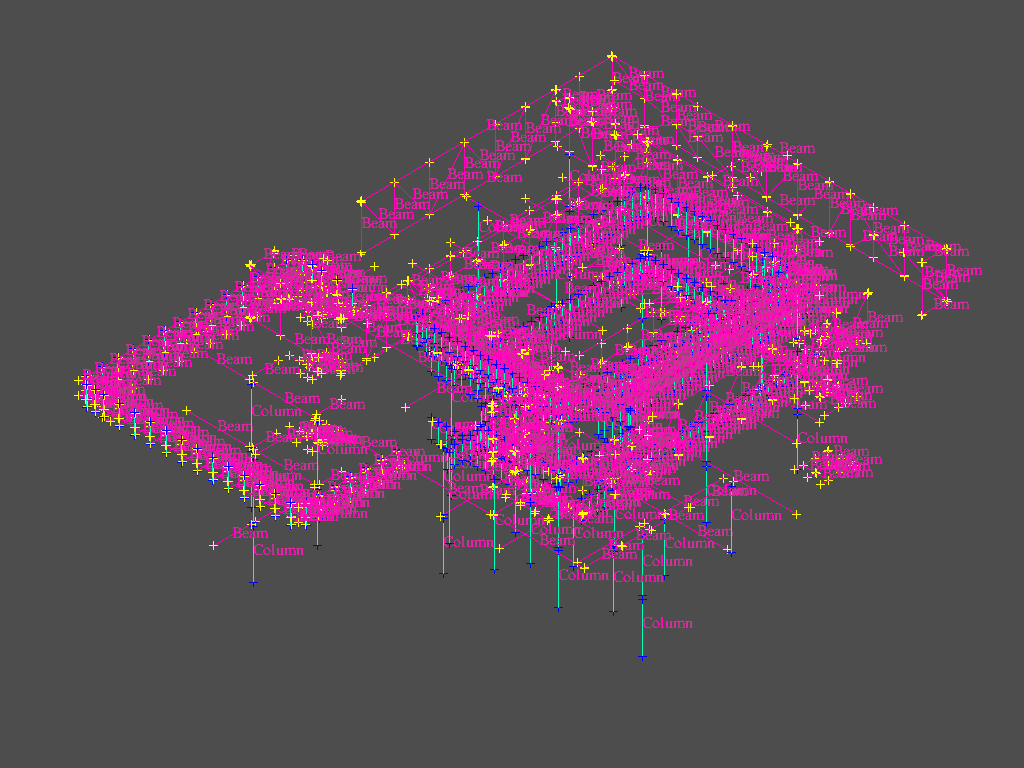

In [26]:
RenderInWindow(RenderStructuralMembersFunc, modelData=modelData, members=members)
RenderImage(RenderStructuralMembersFunc, modelData=modelData, members=members)